In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import socket
import time
import os
import gc
import datetime
import logging

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [2]:
#Finally, import our simulator
from GPUSimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, IPythonMagic
from GPUSimulators.helpers import InitialConditions

In [3]:
%setup_logging log_name
%cuda_context_handler cuda_context

Console logger using level INFO
File logger using level DEBUG to output.log
Python version 3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:37:05) [GCC 13.3.0]
Registering cuda_context in user workspace
PyCUDA version 2024.1
CUDA version (11, 8, 0)
Driver version 12040
Using device 0/1 'Quadro GV100' (0000:01:00.0) GPU
Created context handle <101430662495744>
Using CUDA cache dir FiniteVolumeGPU/GPUSimulators/cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience


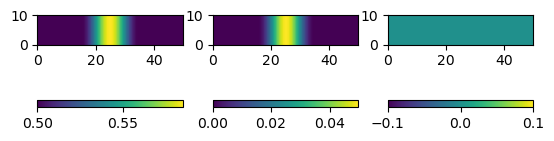

In [4]:
# Initial conditions
nx = 100
ny = 2
ref_nx = 1000
width = 50
height = width/5
bump_size = 10
h, hu, hv, dx, dy = InitialConditions.bump(nx=nx, ny=ny, width=width, height=height, bump_size=bump_size, ref_nx=ref_nx, v_amp=0, v_ref=0)

# Show those conditions
plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, nx*dx, 0, ny*dy])
plt.colorbar(orientation='horizontal')

plt.show()

In [5]:
def gen_filename(simulator, nx):
    return os.path.abspath(os.path.join("data", "smooth1d", str(simulator.__name__) + "_" + str(nx) + ".npz"))

In [6]:
def run_benchmark(datafilename, simulator, simulator_args, nx, reference_nx, ny, reference_ny,
                  h_ref=0.5, h_amp=0.1, u_ref=0.0, u_amp=0.1, v_ref=0.0, v_amp=0.1,
                  dt=None, force_rerun=False, transpose=False):
    if (datafilename and os.path.isfile(datafilename) and force_rerun == False):
        print("WARNING: Existing simulation exists, skipping simulation run")
        return [0, 0, 0]
    else:
        width = 100
        test_data_args = {
            'nx': nx,
            'ny': ny,
            'width': width,
            'height': height,
            'bump_size': width/5,
            'ref_nx': reference_nx,
            'ref_ny': reference_ny,
            'h_ref': h_ref, 'h_amp': h_amp,
            'u_ref': u_ref, 'u_amp': u_amp,
            'v_ref': v_ref, 'v_amp': v_amp
        }
        h0, hu0, hv0, dx, dy = InitialConditions.bump(**test_data_args)
        # Initialise simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            if (transpose):
                h0 = np.ascontiguousarray(np.transpose(h0))
                hu0, hv0 = np.ascontiguousarray(np.transpose(hv0)), np.ascontiguousarray(np.transpose(hu0))
                dx, dy = dy, dx
                nx, ny = ny, nx

            sim_args = {
                'h0': h0, 'hu0': hu0, 'hv0': hv0,
                'nx': nx, 'ny': ny,
                'dx': dx, 'dy': dy
            }
            sim_args.update(simulator_args)

            sim = simulator(**sim_args)
            # final time, number of steps, and computing time reported by pycuda
            t,  nt, elapsed_time = sim.simulate(1.0, dt=None)
            sim.check()

            nt = sim.simSteps()
            dt = sim.simTime() / nt
            h, hu, hv = sim.download()

            if (transpose):
                h = np.ascontiguousarray(np.transpose(h))
                hu, hv = np.ascontiguousarray(np.transpose(hv)), np.ascontiguousarray(np.transpose(hu))

            if (datafilename):
                dirname = os.path.dirname(datafilename)
                if (dirname and not os.path.isdir(dirname)):
                    os.makedirs(dirname)
                np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)

    gc.collect() # Force garbage collection
    return [elapsed_time, nt, dt]

In [7]:
logger = logging.getLogger(__name__)
sim_args = {
    'context': cuda_context,
    'cfl_scale': 0.9,
    'g': 9.81
}
g = 9.81
H_REF = 0.5
H_AMP = 0.1
U_REF = 0.0
U_AMP = 0.1
force_rerun = True
transpose = False

# Reference solution computed by just running simulators on finer meshes
reference_nx = 32768
# Must be factors of `reference_nx` for downsampling to work
domain_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
# Constants for calculating norms
reference_dx = width / reference_nx
dxs = width / np.array(domain_sizes)

simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]

# Make space to store
sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros_like(sim_elapsed_time)
sim_nt = np.zeros_like(sim_elapsed_time)
sim_errors = np.zeros_like(sim_elapsed_time)
sim_cons = np.zeros_like(sim_elapsed_time)

# TODO FIXME warmup!

for i in range(len(simulators)):
    # Run reference with a low CFL-number. TODO IT DOES NOT!
    # This should also serve as warmup for now? TODO
    datafilename = gen_filename(simulators[i], reference_nx)
    secs, _, _ = run_benchmark(datafilename, 
                          simulators[i],
                          sim_args,
                          reference_nx, reference_nx, 2, 2,
                          h_ref=H_REF, h_amp=H_AMP,
                          u_ref=U_REF, u_amp=U_AMP,
                          v_ref=0.0, v_amp=0.0,
                          #dt=0.25*0.7*(width/reference_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                          force_rerun=force_rerun,
                          transpose=transpose)
    with np.load(datafilename) as data:
        h_ref = data['h'].astype(np.float128)
    logger.info(f"{simulators[i].__name__} completed reference simulation in {secs}s.")

    # Run on all the sizes
    for j, nx in enumerate(domain_sizes):
        datafilename = gen_filename(simulators[i], nx)
        secs, nt, dt = run_benchmark(datafilename, 
                          simulators[i],
                          sim_args,
                          nx, reference_nx, 2, 2,
                          h_ref=H_REF, h_amp=H_AMP,
                          u_ref=U_REF, u_amp=U_AMP,
                          v_ref=0.0, v_amp=0.0,
                          #dt=0.25*0.7*(width/reference_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                          force_rerun=force_rerun,
                          transpose=transpose)
        with np.load(datafilename) as data:
            h = data['h'].astype(np.float128)
        logger.info(f"{simulators[i].__name__} completed {nx}-celled simulation in {secs}s.")
        # downsample
        h_ref_downsampled = InitialConditions.downsample(h_ref, reference_nx / nx, 1)

        # error calculation
        dx = dxs[j]
        error = np.linalg.norm((h_ref_downsampled - h).flatten(), ord = 1) * dx
        conservation = (np.sum(h_ref) * reference_dx - np.sum(h) * dx)

        # store
        sim_elapsed_time[i, j] = secs
        sim_nt[i, j] = nt
        sim_dt[i, j] = dt
        sim_errors[i, j] = error
        sim_cons[i, j] = conservation
    # _ to prevent output being printed to the screen
    _ = gc.collect()

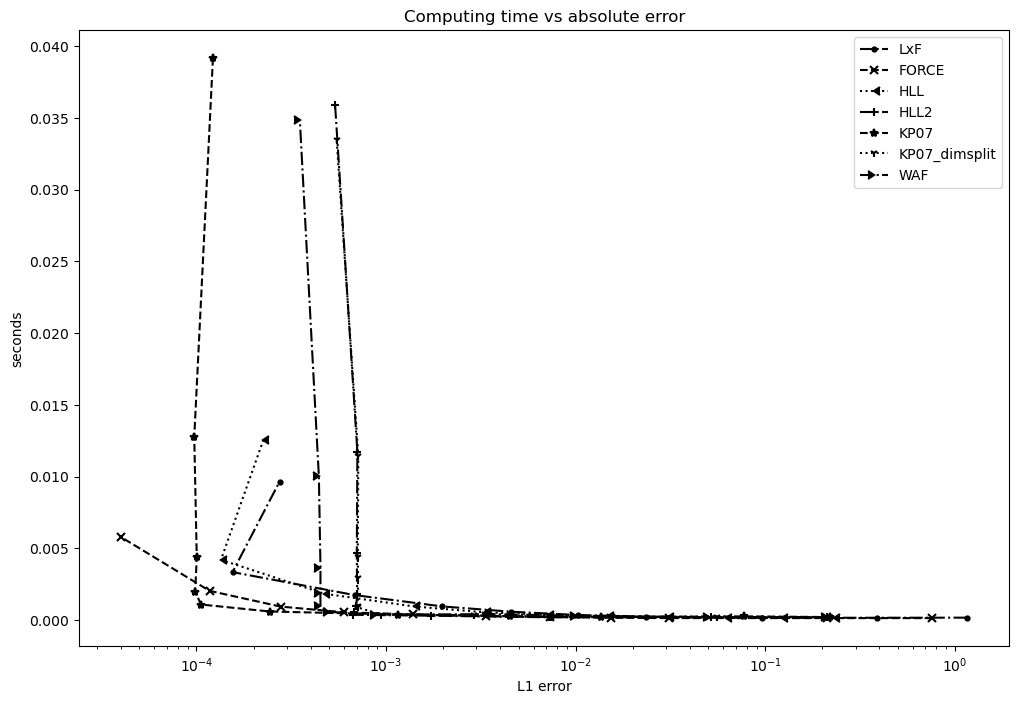

In [9]:
# Plot the timing and error data
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
miscPlotting.setBwStyles(fig.gca())
plt.title("Computing time vs absolute error")

for i, simulator in enumerate(simulators):
    plt.loglog(sim_errors[i,:], sim_elapsed_time[i,:], label = simulator.__name__)
    plt.xlabel("L1 error")
    plt.ylabel("seconds")

plt.legend()
miscPlotting.save_figure(fig, "time_to_solution")